
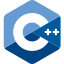
<br>

<div style="text-align:center; font-size:200%;">
 <b>GoF: Observer Pattern</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 06 GoF Observer Pattern.ipynb -->
<!-- slides/module_450_design_patterns/topic_240_observer.cpp -->


## Observer

### Zweck

- 1:n Beziehung zwischen Objekten
- Automatische Benachrichtigung aller abhängigen Objekte bei Zustandsänderung

### Motivation

- Konsistenz zwischen zusammenhängenden Objekten erhalten
- Dabei aber lose Kopplung erhalten
- Ein *Subject* kann beliebig viele *Observers* haben
- *Observer* werden automatisch über Änderungen am *Subject* benachrichtigt


### Beispiel: Aktienkurse

- Aktienkurse ändern sich ständig
- Viele verschiedene Anwendungen wollen über Änderungen informiert werden
- Anwendungen sollen unabhängig voneinander sein
- Die Anwendung soll nicht über konkrete Applikationen Bescheid wissen


### Klassendiagramm

<img src="img/stock_example.svg"
     style="display:block;margin:auto;width:90%"/>

In [ ]:
#include <cmath>
#include <iostream>
#include <memory>
#include <random>
#include <string>
#include <unordered_map>
#include <vector>

In [ ]:
class Stock {
public:
    Stock(std::string name, double price) : name(name), price(price) {}

    std::string GetName() const { return name; }
    double GetPrice() const { return price; }

    void SetPrice(double new_price) { price = new_price; }

private:
    std::string name;
    double price;
};

In [ ]:
class StockObserver {
public:
    StockObserver() = default;
    StockObserver(const StockObserver&) = delete;
    StockObserver& operator=(const StockObserver&) = delete;
    StockObserver(StockObserver&&) = delete;
    StockObserver& operator=(StockObserver&&) = delete;
    virtual ~StockObserver() = default;

    virtual void NoteUpdatedPrices(const std::vector<Stock*>& stocks) = 0;
}

In [ ]:
class StockMarket {
public:
    void AddStock(std::unique_ptr<Stock> stock);
    void AttachObserver(std::shared_ptr<StockObserver> observer);
    void UpdatePrices();

private:
    std::size_t GetNumStocksToSelect() const;
    std::vector<Stock*> SelectStocksToUpdate() const;
    void UpdatePricesFor(std::vector<Stock*> stocks) const;
    void NotifyObservers(const std::vector<Stock*>& stocks);

    std::unordered_map<std::string, std::unique_ptr<Stock>> stocks;
    std::vector<std::weak_ptr<StockObserver>> observers;
    std::random_device rd;
    mutable std::mt19937 gen{rd()};
    mutable std::normal_distribution<> price_dist{1.0, 0.3};
};

In [ ]:
void StockMarket::AddStock(std::unique_ptr<Stock> stock) {
    std::string name{stock->GetName()};
    stocks[name] = std::move(stock);
}

In [ ]:
void StockMarket::AttachObserver(std::shared_ptr<StockObserver> observer) {
    observers.push_back(observer);
}

In [ ]:
void StockMarket::UpdatePrices() {
    auto stocks{SelectStocksToUpdate()};
    UpdatePricesFor(stocks);
    NotifyObservers(stocks);
}

In [ ]:
std::size_t StockMarket::GetNumStocksToSelect() const {
    auto percent_dist{std::binomial_distribution<std::size_t>(stocks.size(), 0.4)};
    return percent_dist(gen);
}

In [ ]:
std::vector<Stock*> StockMarket::SelectStocksToUpdate() const {
    std::vector<Stock*> stocksToUpdate;
    stocksToUpdate.reserve(stocks.size());
    std::transform(
        stocks.begin(), stocks.end(), std::back_inserter(stocksToUpdate),
        [](const auto& entry) { return entry.second.get(); });
    std::shuffle(stocksToUpdate.begin(), stocksToUpdate.end(), gen);
    stocksToUpdate.resize(GetNumStocksToSelect());
    return stocksToUpdate;
}

In [ ]:
void StockMarket::UpdatePricesFor(std::vector<Stock*> stocks) const {
    for (auto stock : stocks) {
        stock->SetPrice(stock->GetPrice() * price_dist(gen));
    }
}

In [ ]:
void StockMarket::NotifyObservers(const std::vector<Stock*>& stocks) {
    for (auto& observer : observers) {
        std::shared_ptr<StockObserver> observer_ptr{observer.lock()};
        if (observer_ptr)
            observer_ptr->NoteUpdatedPrices(stocks);
    }
}

In [ ]:
class PrintingStockObserver : public StockObserver {
public:
    PrintingStockObserver(std::string name) : name(name) {}

    void NoteUpdatedPrices(const std::vector<Stock*>& stocks) override {
        std::cout << "PrintingStockObserver " << name << " received update:\n";
        for (auto stock : stocks) {
            std::cout << "  " << stock->GetName() << ": " << stock->GetPrice() << "\n";
        }
    }

private:
    std::string name;
};

In [ ]:
class RisingStockObserver : public StockObserver {
public:
    RisingStockObserver(std::string name) : name(name) {}

    void NoteUpdatedPrices(const std::vector<Stock*>& stocks) override {
        std::cout << "RisingStockObserver " << name << " received update:\n";
        for (auto stock : stocks) {
            auto oldPrice{oldPrices[stock->GetName()]};
            if (stock->GetPrice() > oldPrice)
                std::cout << "  " << stock->GetName() << ": " << oldPrice << " -> "
                          << stock->GetPrice() << "\n";
            oldPrices[stock->GetName()] = stock->GetPrice();
        }
    }

private:
    std::string name;
    std::unordered_map<std::string, double> oldPrices;
};

In [ ]:
StockMarket market;

In [ ]:
auto printingObserver{std::make_shared<PrintingStockObserver>("PrintingObserver")};
auto risingObserver{std::make_shared<RisingStockObserver>("RisingObserver")};

In [ ]:
market.AttachObserver(printingObserver);
market.AttachObserver(risingObserver);

In [ ]:
market.AddStock(std::make_unique<Stock>("Banana", 100.0));
market.AddStock(std::make_unique<Stock>("Billionz", 200.0));
market.AddStock(std::make_unique<Stock>("Macrosoft", 300.0));
market.AddStock(std::make_unique<Stock>("BCD", 400.0));

In [ ]:
for (int i = 0; i < 10; ++i) {
    std::cout << "============= Update " << i + 1 << " =============\n";
    market.UpdatePrices();
}

In [ ]:
printingObserver.reset();

In [ ]:
for (int i = 0; i < 10; ++i) {
    std::cout << "============= Update " << i + 1 << " =============\n";
    market.UpdatePrices();
}


### Anwendbarkeit

- Ein Objekt muss andere Objekte benachrichtigen, ohne Details zu kennen
- Eine Änderung in einem Objekt führt zu Änderungen in (beliebig vielen)
  anderen Objekten
- Eine Abstraktion hat zwei Aspekte, wobei einer vom anderen abhängt


### Struktur: Pull Observer

<img src="img/pat_observer_pull.svg"
     style="display:block;margin:auto;width:100%"/>


## Observer (Behavioral Pattern)

### Teilnehmer

- `Subject`
  - kennt seine Observer. Jede Anzahl von Observern kann ein Subject
    beobachten
  - stellt eine Schnittstelle zum Hinzufügen und Entfernen von Observern
    bereit
- `Observer`
  - definiert eine Aktualisierungs-Schnittstelle für Objekte, die über
    Änderungen eines Subjects informiert werden sollen


- `ConcreteSubject`
  - Speichert den Zustand, der für `ConcreteObserver`-Objekte von Interesse
    ist
  - Sendet eine Benachrichtigung an seine Observer, wenn sich sein Zustand
    ändert
- `ConcreteObserver`
  - Kann eine Referenz auf ein `ConcreteSubject`-Objekt halten
  - Speichert Zustand, der mit dem des Subjects konsistent bleiben soll
  - Implementiert die `Observer`-Aktualisierungs-Schnittstelle, um seinen
    Zustand mit dem des Subjects konsistent zu halten


### Interaktionen: Pull Observer

<img src="img/pat_observer_pull_seq.svg"
     style="display:block;margin:auto;width:65%"/>


### Interaktionen

- `ConcreteSubject` benachrichtigt seine Observer über Änderungen in seinem
  Zustand
- Nachdem ein `ConcreteObserver` über eine Änderung im `ConcreteSubject`
  informiert wurde, holt es den neuen Zustand vom Subjekt
- `ConcreteObserver` verwendet diese Informationen, um seinen Zustand mit dem
  des Subjects in Einklang zu bringen


### Struktur: Push Observer

<img src="img/pat_observer_push.svg"
     style="display:block;margin:auto;width:100%"/>


### Interaktion: Push Observer

<img src="img/pat_observer_push_seq.svg"
     style="display:block;margin:auto;width:65%"/>


### Konsequenzen

- `Subject` und `Observer` können unabhängig voneinander
   - variiert werden
   - wiederverwendet werden
- Hinzufügen neuer `Observer` ohne Änderungen am `Subject`
- Abstrakte Kopplung zwischen `Subject` und `Observer`
- Unterstützung für Broadcast-Kommunikation
- Unerwartete Updates


### Praxisbeispiele

- Event-Listener in Benutzeroberflächen (SWT)

### Verwandte Patterns

- Mediator: Durch die Kapselung komplexer Update-Semantik fungiert der
  `ChangeManager` als Mediator zwischen Subjects und Observers
- Singleton: ...


## Workshop: Produktion von Werkstücken

In einem Produktionssystem wollen Sie verschiedene andere System
benachrichtigen, wenn Sie ein Werkstück erzeugt haben. Dabei sollen diese
Systeme vom konkreten Produzenten unabhängig sein und auch der Produzent
keine (statische) Kenntnis über die benachrichtigten System haben.

Implementieren Sie ein derartiges System mit dem Observer-Pattern.
Implementieren Sie dazu einen konkreten Observer `PrintingObserver`, der den
Zustand des beobachteten Objekts ausgibt.

*Hinweis:* Sie können das System sowohl mit Pull- als auch mit Push-Observern
implementieren. Es ist eine gute Übung, wenn Sie beide Varianten
implementieren und vergleichen.

In [ ]:
class PullObserver : public std::enable_shared_from_this<PullObserver> {
public:
    PullObserver() = default;
    PullObserver(const PullObserver&) = delete;
    PullObserver& operator=(const PullObserver&) = delete;
    PullObserver(PullObserver&&) = delete;
    PullObserver& operator=(PullObserver&&) = delete;
    virtual ~PullObserver() = default;

    virtual void Update() = 0;
    virtual int GetId() const = 0;
};

In [ ]:
struct PrintVec {
    const std::vector<int> v;
};

In [ ]:
// To work around a bug in notebooks
#define OP operator<<

In [ ]:
std::ostream& OP(std::ostream& os, const PrintVec& vec) {
    os << "[";
    std::string sep;
    for (auto i : vec.v) {
        os << sep << i;
        sep = ", ";
    }
    os << "]";
    return os;
}

In [ ]:
class PullSubject {
public:
    void Attach(PullObserver& observer) {
        observers.emplace_back(observer.weak_from_this());
        PrintObservers("after attaching");
    }

    void Detach(PullObserver& observer) {
        observers.erase(
            std::remove_if(
                observers.begin(), observers.end(),
                [&observer](const auto& o) {
                    return o.lock() && (o.lock().get() == &observer);
                }),
            observers.end());
        PrintObservers("after detaching");
    }

    void Notify() {
        PrintObservers("before notifying");
        for (auto o : observers) {
            auto observer_ptr{o.lock()};
            if (observer_ptr) {
                observer_ptr->Update();
            }
        }
    }

    virtual std::vector<int> GetState() const = 0;

private:
    void PrintObservers(std::string_view context) {
        std::cout << "Observers " << context << " are:";
        for (auto o : observers) {
            auto observer_ptr{o.lock()};
            if (observer_ptr) {
                std::cout << " Observer-" << observer_ptr->GetId();
            } else {
                std::cout << " Observer-<deleted>";
            }
        }
        std::cout << "\n";
    }
    std::vector<std::weak_ptr<PullObserver>> observers;
};

In [ ]:
class PrintingPullObserver : public PullObserver {
public:
    PrintingPullObserver(int id) : id{id} {}

    void Update() override {
        std::cout << "Observer " << id << ": Observing " << subject << ".\n";
        std::cout << "  Old observer state is " << PrintVec{observerState} << ".\n";
        observerState = subject->GetState();
        std::cout << "  New observer state is " << PrintVec{observerState} << ".\n";
    }

    int GetId() const override { return id; }

    void AttachTo(PullSubject& subject) {
        subject.Attach(*this);
        this->subject = &subject;
    }

    void DetachFromSubject() {
        if (subject != nullptr) {
            subject->Detach(*this);
            subject = nullptr;
        }
    }

private:
    int id{};
    PullSubject* subject{};
    std::vector<int> observerState{};
};

In [ ]:
class PullProducer : public PullSubject {
public:
    void ProduceItem(int item) {
        availableItems.push_back(item);
        Notify();
    }

    std::vector<int> GetState() const override { return availableItems; }

private:
    std::vector<int> availableItems;
};

In [ ]:
PullProducer p{};
auto o1{std::make_shared<PrintingPullObserver>(1)};
o1->AttachTo(p);
auto o2{std::make_shared<PrintingPullObserver>(2)};
o2->AttachTo(p);

In [ ]:
p.ProduceItem(1);
p.ProduceItem(2);

In [ ]:
o1->DetachFromSubject();
p.ProduceItem(3);

In [ ]:
o1->AttachTo(p);
o2.reset();
p.ProduceItem(4);

In [ ]:
class PushObserver : public std::enable_shared_from_this<PushObserver> {
public:
    PushObserver() = default;
    PushObserver(const PushObserver&) = delete;
    PushObserver& operator=(const PushObserver&) = delete;
    PushObserver(PushObserver&&) = delete;
    PushObserver& operator=(PushObserver&&) = delete;
    virtual ~PushObserver() = default;

    virtual void Update(int item) = 0;
    virtual int GetId() const = 0;
};

In [ ]:
class PushSubject {
public:
    void Attach(PushObserver& observer) {
        observers.emplace_back(observer.weak_from_this());
        PrintObservers("after attaching");
    }

    void Detach(PushObserver& observer) {
        observers.erase(
            std::remove_if(
                observers.begin(), observers.end(),
                [&observer](const auto& o) {
                    return o.lock() && (o.lock().get() == &observer);
                }),
            observers.end());
        PrintObservers("after detaching");
    }

    void Notify(int item) {
        PrintObservers("before notifying");
        for (auto o : observers) {
            auto observer_ptr{o.lock()};
            if (observer_ptr) {
                observer_ptr->Update(item);
            }
        }
    }

private:
    void PrintObservers(std::string_view context) {
        std::cout << "Observers " << context << " are:";
        for (auto o : observers) {
            auto observer_ptr{o.lock()};
            if (observer_ptr) {
                std::cout << " Observer-" << observer_ptr->GetId();
            } else {
                std::cout << " Observer-<deleted>";
            }
        }
        std::cout << "\n";
    }
    std::vector<std::weak_ptr<PushObserver>> observers;
};

In [ ]:
class PrintingPushObserver : public PushObserver {
public:
    PrintingPushObserver(int id) : id{id} {}

    void Update(int item) override {
        std::cout << "Observer " << id << "\n";
        std::cout << "  Received item " << item << ".\n";
    }

    int GetId() const override { return id; }

private:
    int id{};
};

In [ ]:
class PushProducer : public PushSubject {
public:
    void ProduceItem(int item) {
        availableItems.push_back(item);
        Notify(item);
    }

private:
    std::vector<int> availableItems;
};

In [ ]:
PushProducer p{};
auto o1{std::make_shared<PrintingPushObserver>(1)};
p.Attach(*o1);
auto o2{std::make_shared<PrintingPushObserver>(2)};
p.Attach(*o2);

In [ ]:
p.ProduceItem(1);
p.ProduceItem(2);

In [ ]:
p.Detach(*o1);
p.ProduceItem(3);

In [ ]:
p.Attach(*o1);
o2.reset();
p.ProduceItem(4);